#  ML model that will predict likelihood of getting H1B approved 

### Problem Statement
It is known that many US open job positions can not be filled due to the lack of qualified resources within the United States. One option that companies are using to solve this shortage is by sponsoring foreign qualified professionals via H1B visas.  Companies will submit applications on behalf of these foreign workers. 

The main outcome that companies and individuals are hoping for is Certified (approved). Besides it, the other potential outcomes are Rejected/Denied/Withdrawn/Pending.  


### Goal of the Project

The goal of my project is to answer the following question: Is it possible to predict if an H1B application will be Certified or not given the selected company sponsor/job title/duration?

### Data Source

The historical data that I will use to answer this question will cover at last fiscal year (Oct 1, 2017- Sept 30, 2018) of H1B visas applications and is available for collection at the Department of Labor. 

### Variables

The project will focus on Company sponsor (Employers), Job Title, process Duration. Note- To calculate the Duration variable, Decision Date and Case submitted date variables are used.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import pylab
import copy

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score




In [2]:
data_q4 = pd.read_excel("..!/data/H-1B_copy.xlsx")

In [3]:
#What is the size of my data?
data_q4.shape


(654360, 52)

In [4]:
data_q4.drop(data_q4.index[3],inplace=True)

In [5]:
data_q4.shape

(654359, 52)

In [6]:
#Given my goal: How many applications were approved/certified? 
data_q4['CASE_STATUS'].value_counts()

CERTIFIED              579448
CERTIFIED-WITHDRAWN     45004
WITHDRAWN               21280
DENIED                   8627
Name: CASE_STATUS, dtype: int64

In [14]:
status = {'Certified': 579448, 'Certified-W': 45004, 'Withdrawn':21280, 'Denied': 8627}
status_k = list(status.keys())
status_v = list(status.values())

Text(0.5, 0.98, 'Status of Applications')

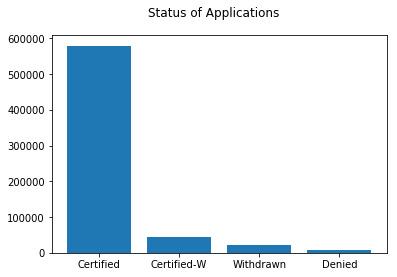

In [15]:
fig, ax = plt.subplots()
ax.bar(status_k, status_v)
fig.suptitle('Status of Applications')

In [7]:
data_q4['DURATION'] = data_q4['DECISION_DATE'] - data_q4['CASE_SUBMITTED']

In [8]:
data_q4['DURATION']= data_q4.DURATION/ np.timedelta64(1, 'h')

In [9]:
data_q4.describe()

,NAICS_CODE,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMP,CHANGE_EMPLOYER,AMENDED_PETITION,PREVAILING_WAGE,PW_SOURCE_YEAR,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,PUBLIC_DISCLOSURE_LOCATION,DURATION
count,654353.000000,654359.000000,654359.000000,654359.000000,654359.000000,654359.000000,654359.000000,654359.000000,6.543560e+05,654292.000000,6.543590e+05,6.543560e+05,0.0,654359.000000
mean,443245.330603,1.981536,0.847396,0.356702,0.144312,0.015667,0.301882,0.316630,8.204631e+04,2017.172493,9.119617e+04,2.565564e+04,NaN,763.137385
std,197179.672671,5.616137,4.037308,1.792550,1.163532,0.276556,1.503982,1.645805,1.236610e+06,3.576551,1.237009e+06,5.643532e+04,NaN,3097.440796
min,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,NaN,0.000000
25%,452112.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.462600e+04,2017.000000,7.000000e+04,0.000000e+00,NaN,144.000000
50%,541511.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.012200e+04,2017.000000,8.560000e+04,0.000000e+00,NaN,144.000000
75%,541511.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.709400e+04,2017.000000,1.080000e+05,0.000000e+00,NaN,144.000000
max,928120.000000,200.000000,200.000000,99.000000,75.000000,50.000000,99.000000,109.000000,1.000000e+09,2107.000000,1.000000e+09,9.103328e+06,NaN,67056.000000


In [10]:
data_q4.head()

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_BUSINESS_DBA,EMPLOYER_ADDRESS,...,WILLFUL_VIOLATOR,SUPPORT_H1B,LABOR_CON_AGREE,PUBLIC_DISCLOSURE_LOCATION,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,ORIGINAL_CERT_DATE,DURATION
0,I-200-18026-338377,CERTIFIED,2018-01-29,2018-02-02,H-1B,2018-07-28,2021-07-27,MICROSOFT CORPORATION,NaN,1 MICROSOFT WAY,...,N,NaN,NaN,NaN,REDMOND,KING,WA,98052,NaT,96.0
1,I-200-17296-353451,CERTIFIED,2017-10-23,2017-10-27,H-1B,2017-11-06,2020-11-06,ERNST & YOUNG U.S. LLP,NaN,200 PLAZA DRIVE,...,N,NaN,NaN,NaN,SANTA CLARA,SAN JOSE,CA,95110,NaT,96.0
2,I-200-18242-524477,CERTIFIED,2018-08-30,2018-09-06,H-1B,2018-09-10,2021-09-09,LOGIXHUB LLC,NaN,320 DECKER DRIVE,...,N,NaN,NaN,NaN,IRVING,DALLAS,TX,75062,NaT,168.0
4,I-200-18243-850522,CERTIFIED,2018-08-31,2018-09-07,H-1B,2018-09-07,2021-09-06,"ECLOUD LABS,INC.",NaN,120 S WOOD AVENUE,...,N,Y,Y,NaN,BIRMINGHAM,SHELBY,AL,35244,NaT,168.0
5,I-200-18142-939501,CERTIFIED,2018-05-22,2018-05-29,H-1B,2018-05-29,2021-05-28,OBERON IT,NaN,1404 W WALNUT HILL LN,...,N,Y,NaN,NaN,SUNRISE,BROWARD,FL,33323,NaT,168.0


In [11]:
data_q4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654359 entries, 0 to 654359
Data columns (total 53 columns):
CASE_NUMBER                    654359 non-null object
CASE_STATUS                    654359 non-null object
CASE_SUBMITTED                 654359 non-null datetime64[ns]
DECISION_DATE                  654359 non-null datetime64[ns]
VISA_CLASS                     654359 non-null object
EMPLOYMENT_START_DATE          654352 non-null datetime64[ns]
EMPLOYMENT_END_DATE            654348 non-null datetime64[ns]
EMPLOYER_NAME                  654340 non-null object
EMPLOYER_BUSINESS_DBA          53490 non-null object
EMPLOYER_ADDRESS               654348 non-null object
EMPLOYER_CITY                  654348 non-null object
EMPLOYER_STATE                 654286 non-null object
EMPLOYER_POSTAL_CODE           654341 non-null object
EMPLOYER_COUNTRY               654352 non-null object
EMPLOYER_PROVINCE              6705 non-null object
EMPLOYER_PHONE                 654352 non-null obj

##  Categorical Data - Features & Label

In [16]:
# Top Employers
data_q4['EMPLOYER_NAME'].value_counts()

DELOITTE CONSULTING LLP                            16140
TATA CONSULTANCY SERVICES LIMITED                  14604
INFOSYS LIMITED                                    11591
COGNIZANT TECHNOLOGY SOLUTIONS US CORP             11086
ERNST & YOUNG U.S. LLP                              6892
ACCENTURE LLP                                       6381
WIPRO LIMITED                                       6306
GOOGLE LLC                                          6099
CAPGEMINI AMERICA INC                               6064
TECH MAHINDRA (AMERICAS),INC.                       5835
MICROSOFT CORPORATION                               5552
IBM CORPORATION                                     5167
AMAZON.COM SERVICES, INC.                           3894
SYNTEL INC                                          3341
IBM INDIA PRIVATE LIMITED                           3152
LARSEN & TOUBRO INFOTECH LIMITED                    3107
FACEBOOK, INC.                                      2731
HCL AMERICA, INC.              

In [17]:
imp_companies = data_q4['EMPLOYER_NAME'].value_counts().index[:50]

In [18]:
data_q4['EMPLOYER_NAME'].loc[~data_q4['EMPLOYER_NAME'].isin(imp_companies)] = 'Other'

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
# Validation
data_q4['EMPLOYER_NAME'].value_counts()

Other                                                                  493653
DELOITTE CONSULTING LLP                                                 16140
TATA CONSULTANCY SERVICES LIMITED                                       14604
INFOSYS LIMITED                                                         11591
COGNIZANT TECHNOLOGY SOLUTIONS US CORP                                  11086
ERNST & YOUNG U.S. LLP                                                   6892
ACCENTURE LLP                                                            6381
WIPRO LIMITED                                                            6306
GOOGLE LLC                                                               6099
CAPGEMINI AMERICA INC                                                    6064
TECH MAHINDRA (AMERICAS),INC.                                            5835
MICROSOFT CORPORATION                                                    5552
IBM CORPORATION                                                 

In [20]:
top_jobs = data_q4['JOB_TITLE'].value_counts().index[:50]

In [21]:
data_q4['JOB_TITLE'].loc[~data_q4['JOB_TITLE'].isin(top_jobs)] = 'Other'

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
data_q4['JOB_TITLE'].value_counts()

Other                                  437175
SOFTWARE DEVELOPER                      34907
SOFTWARE ENGINEER                       31942
PROGRAMMER ANALYST                      14109
SENIOR SOFTWARE ENGINEER                 8430
SENIOR SYSTEMS ANALYST JC60              7041
DEVELOPER                                6244
SYSTEMS ANALYST                          6131
CONSULTANT                               6004
ASSISTANT PROFESSOR                      5302
BUSINESS ANALYST                         5145
SENIOR CONSULTANT                        4925
ANALYST                                  4821
PROJECT MANAGER                          3904
JAVA DEVELOPER                           3578
SENIOR SOFTWARE DEVELOPER                3516
ASSOCIATE                                3501
COMPUTER SYSTEMS ANALYST                 3337
DATABASE ADMINISTRATOR                   2980
ENGINEER                                 2927
COMPUTER PROGRAMMER                      2926
APPLICATION DEVELOPER             

In [23]:
wage_level = data_q4['PW_WAGE_LEVEL'].value_counts().index[:50]

In [24]:
data_q4['PW_WAGE_LEVEL'].loc[~data_q4['PW_WAGE_LEVEL'].isin(wage_level)] = 'Other'

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
data_q4['PW_WAGE_LEVEL'].value_counts()

Level II     330833
Level I      111751
Level III    110846
Level IV      62711
Other         38218
Name: PW_WAGE_LEVEL, dtype: int64

In [26]:
top_zipcodes = data_q4['WORKSITE_POSTAL_CODE'].value_counts().index[:50]

In [27]:
data_q4['WORKSITE_POSTAL_CODE'].loc[~data_q4['WORKSITE_POSTAL_CODE'].isin(top_zipcodes)] = 'Other'

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
data_q4['WORKSITE_POSTAL_CODE'].value_counts()

Other    507875
94043      7195
98052      6977
94105      6747
19103      5373
95054      5023
94085      4722
95134      4405
75024      4279
60606      3997
10036      3710
94089      3690
94103      3207
94025      2955
22102      2914
94107      2893
98004      2872
75039      2866
10017      2827
94304      2794
10019      2758
95131      2662
94538      2626
10022      2585
98109      2460
10001      2431
28202      2416
60015      2401
98101      2324
30005      2300
07302      2262
08540      2193
94588      2187
08873      2163
98121      2162
95014      2125
77002      2043
75201      2022
75063      1993
95035      1983
48326      1976
30339      1973
10004      1945
10005      1921
10018      1906
94111      1902
75038      1894
08854      1878
94404      1874
27709      1837
28262      1836
Name: WORKSITE_POSTAL_CODE, dtype: int64

In [29]:
# Fill out the missing observations for the variables with the most frequent one
data_q4 = data_q4.fillna({"AGENT_REPRESENTING_EMPLOYER":"Y"})
data_q4 = data_q4.fillna({"FULL_TIME_POSITION": "Y"})

In [30]:
features = data_q4[['EMPLOYER_NAME', 'JOB_TITLE', 'FULL_TIME_POSITION', 'DURATION', 'WAGE_RATE_OF_PAY_FROM','WORKSITE_POSTAL_CODE','PW_WAGE_LEVEL']]
features.head()

,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,DURATION,WAGE_RATE_OF_PAY_FROM,WORKSITE_POSTAL_CODE,PW_WAGE_LEVEL
0,MICROSOFT CORPORATION,SOFTWARE ENGINEER,Y,96.0,143915.0,98052,Level II
1,ERNST & YOUNG U.S. LLP,Other,Y,96.0,100000.0,Other,Level II
2,Other,DATABASE ADMINISTRATOR,Y,168.0,78240.0,Other,Level II
4,Other,Other,Y,168.0,95000.0,Other,Level III
5,Other,Other,Y,168.0,74000.0,Other,Level II


In [31]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654359 entries, 0 to 654359
Data columns (total 7 columns):
EMPLOYER_NAME            654359 non-null object
JOB_TITLE                654359 non-null object
FULL_TIME_POSITION       654359 non-null object
DURATION                 654359 non-null float64
WAGE_RATE_OF_PAY_FROM    654359 non-null float64
WORKSITE_POSTAL_CODE     654359 non-null object
PW_WAGE_LEVEL            654359 non-null object
dtypes: float64(2), object(5)
memory usage: 39.9+ MB


In [32]:
features_enc = pd.get_dummies(features)

In [33]:
features_enc.head()

,DURATION,WAGE_RATE_OF_PAY_FROM,EMPLOYER_NAME_ACCENTURE LLP,"EMPLOYER_NAME_AMAZON WEB SERVICES, INC.","EMPLOYER_NAME_AMAZON.COM SERVICES, INC.",EMPLOYER_NAME_APPLE INC.,EMPLOYER_NAME_BANK OF AMERICA N.A.,EMPLOYER_NAME_CAPGEMINI AMERICA INC,EMPLOYER_NAME_COGNIZANT TECHNOLOGY SOLUTIONS U.S. CORPORATION,EMPLOYER_NAME_COGNIZANT TECHNOLOGY SOLUTIONS US CORP,...,WORKSITE_POSTAL_CODE_98052,WORKSITE_POSTAL_CODE_98101,WORKSITE_POSTAL_CODE_98109,WORKSITE_POSTAL_CODE_98121,WORKSITE_POSTAL_CODE_Other,PW_WAGE_LEVEL_Level I,PW_WAGE_LEVEL_Level II,PW_WAGE_LEVEL_Level III,PW_WAGE_LEVEL_Level IV,PW_WAGE_LEVEL_Other
0,96.0,143915.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,96.0,100000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,168.0,78240.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,168.0,95000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
5,168.0,74000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [34]:
# Label- What I want to predict?
data_q4['CASE_STATUS'].head(10)


0     CERTIFIED
1     CERTIFIED
2     CERTIFIED
4     CERTIFIED
5     CERTIFIED
6     CERTIFIED
7     CERTIFIED
8     CERTIFIED
9     CERTIFIED
10    CERTIFIED
Name: CASE_STATUS, dtype: object

In [35]:
data_q4['CASE_STATUS'].loc[data_q4['CASE_STATUS'] != 'CERTIFIED'] = 0
data_q4['CASE_STATUS'].loc[data_q4['CASE_STATUS'] == 'CERTIFIED'] = 1

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
# Validation
data_q4['CASE_STATUS'].value_counts()

1    579448
0     74911
Name: CASE_STATUS, dtype: int64

In [37]:
# Assign Case Status to Label
label = data_q4['CASE_STATUS']

## ML Models: Iteration 1

In [38]:
# Split dataset 
F_train, F_test, l_train, l_test = train_test_split(features_enc, label, test_size =.25)

In [39]:
F_train.shape, F_test.shape, l_train.shape, l_test.shape

((490769, 162), (163590, 162), (490769,), (163590,))

In [40]:
X_train, X_val, ltrain, lval = train_test_split(F_train, l_train, test_size=0.25)

In [41]:
X_train.shape, X_val.shape, ltrain.shape, lval.shape

((368076, 162), (122693, 162), (368076,), (122693,))

In [42]:
# Initalize Logistic Regression
logregr = LogisticRegression()

# Train Model
logregr.fit(X_train, ltrain)

# Test Model
y_pred = logregr.predict(F_test)

In [43]:
# Initalize Decision Tree- Gini

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 

treeclass = DecisionTreeClassifier()

# Train Model 
treeclass.fit(X_train, ltrain)

# Predict
ypredictt = treeclass.predict(F_test)

In [44]:
# Inititalize Decision Tree- Entropy
tc_entropy = DecisionTreeClassifier(criterion = "entropy")
tc_entropy.fit(X_train, ltrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [45]:
# Predict entropy 
ypredicte = tc_entropy.predict(F_test)

In [46]:
# Initalize Random Forest 
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_estimators=100)

# Train 
rfc.fit(X_train, ltrain)

# Predict 

ypredictr=rfc.predict(F_test)


In [47]:
# 4. Initialize Gradient Boosting- Default model 

from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)

# Train
clf.fit(X_train, ltrain)

# Predict
ypredictg = clf.predict(F_test)




### How good is my model?

In [48]:
# Logistic Regression
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("LogR Accuracy:",accuracy_score(l_test, y_pred))
print("LogR Precision:",precision_score(l_test, y_pred))
print("LogR Recall:",recall_score(l_test, y_pred))`

LogR Accuracy: 0.8847729078794547
LogR Precision: 0.9368986257275458
LogR Recall: 0.9326413778339445


My Logistic Model is accurate 89% of the time. It was correct 94% of the time when it predicted applicants that are going to get the "certification status" on their H1B visa applications. If there are applicants that will get the certification status in the test set, my Logistic Regression model can identify it 93% of the time.

In [49]:
# Logistic Reg
con_matrix = confusion_matrix(l_test, y_pred)
con_matrix

array([[  9687,   9096],
       [  9754, 135053]])

Text(0.5, 257.44, 'Predicted label')

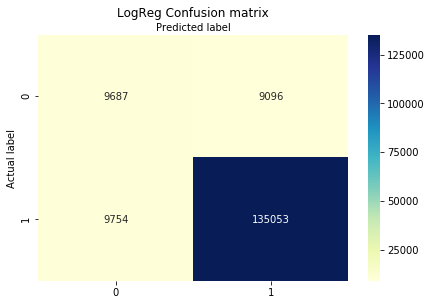

In [50]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(con_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('LogReg Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

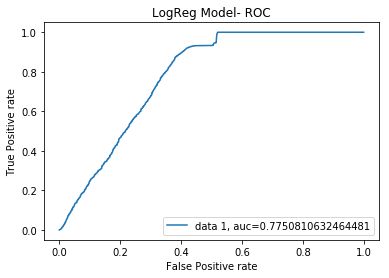

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_pred_prob = logregr.predict_proba(F_test)[:,1]
fpr, tpr, _ = roc_curve(l_test,  y_pred_prob)
auc = roc_auc_score(l_test, y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.title('LogReg Model- ROC')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend(loc=4)
plt.show()

In [52]:
# Decision Tree
from sklearn.metrics import classification_report, confusion_matrix  
cont_matrix = confusion_matrix(l_test, ypredictt)  
print(cont_matrix)

[[ 16949   1834]
 [  1253 143554]]


Text(0.5, 257.44, 'Predicted label')

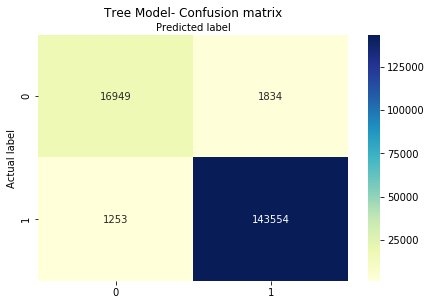

In [53]:
cl_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(cl_names))
plt.xticks(tick_marks, cl_names)
plt.yticks(tick_marks, cl_names)

# create heatmap
sns.heatmap(pd.DataFrame(cont_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Tree Model- Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [54]:
# Classification for Tree 
print(classification_report(l_test, ypredictt))  

             precision    recall  f1-score   support

          0       0.93      0.90      0.92     18783
          1       0.99      0.99      0.99    144807

avg / total       0.98      0.98      0.98    163590



In [55]:
# Tree Classification - Accuracy Score
print("TC Accuracy:", accuracy_score(l_test, ypredictt))

TC Accuracy: 0.9811296534017971


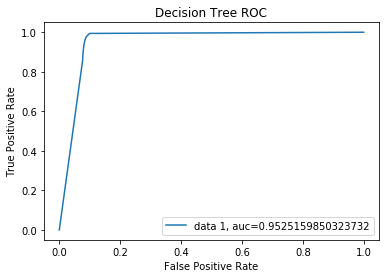

In [56]:
# ROC Curve for Decision Tree
y_dt_prob = treeclass.predict_proba(F_test)[:,1]
fpr_t, tpr_t, _ = roc_curve(l_test,  y_dt_prob)
auc = roc_auc_score(l_test, y_dt_prob)
plt.plot(fpr_t,tpr_t,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC')
plt.legend(loc=4)
plt.show()

In [57]:
# Random Forest 
print("RF Accuracy:",accuracy_score(l_test, ypredictr))

RF Accuracy: 0.9839965768078733


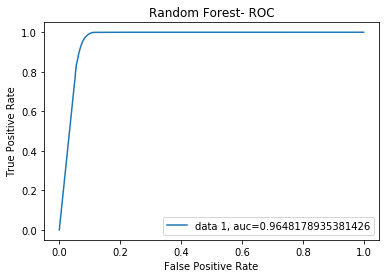

In [58]:
y_r_prob = rfc.predict_proba(F_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(l_test,  y_r_prob)
auc = roc_auc_score(l_test, y_r_prob)
plt.plot(fpr_rf,tpr_rf,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest- ROC')
plt.legend(loc=4)
plt.show()

In [59]:
# Gradient Score
print("GB Accuracy:", clf.score(F_test, l_test))

GB Accuracy: 0.9860932819854514


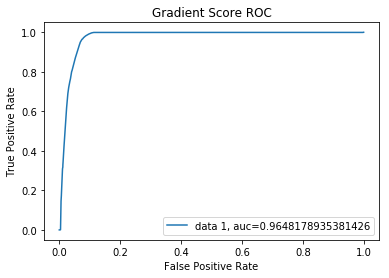

In [60]:
y_g_prob = clf.predict_proba(F_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(l_test,  y_g_prob)
auc = roc_auc_score(l_test, y_r_prob)
plt.plot(fpr_grd,tpr_grd,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Score ROC')
plt.legend(loc=4)
plt.show()

### Important Features

In [61]:
feature_names = X_train.columns.values

In [62]:
# Random Forest 
feat_vip = pd.Series(rfc.feature_importances_).sort_values(ascending=False)
feat_positions = feat_vip.index.values
feat_vip.index = feature_names[feat_positions]
feat_vip

DURATION                                                                             0.883258
WAGE_RATE_OF_PAY_FROM                                                                0.072627
PW_WAGE_LEVEL_Level I                                                                0.005275
EMPLOYER_NAME_Other                                                                  0.004147
JOB_TITLE_PROGRAMMER ANALYST                                                         0.002919
PW_WAGE_LEVEL_Level II                                                               0.002379
EMPLOYER_NAME_HEXAWARE TECHNOLOGIES, INC.                                            0.001990
PW_WAGE_LEVEL_Other                                                                  0.001033
JOB_TITLE_Other                                                                      0.000928
EMPLOYER_NAME_IBM CORPORATION                                                        0.000892
PW_WAGE_LEVEL_Level III                                     

In [63]:
# Gradient Boosting
featvip = pd.Series(clf.feature_importances_).sort_values(ascending=False)
feat_posi= featvip.index.values
featvip.index = feature_names[feat_positions]
featvip

DURATION                                                                             0.662293
WAGE_RATE_OF_PAY_FROM                                                                0.165230
PW_WAGE_LEVEL_Level I                                                                0.158096
EMPLOYER_NAME_Other                                                                  0.008137
JOB_TITLE_PROGRAMMER ANALYST                                                         0.002277
PW_WAGE_LEVEL_Level II                                                               0.001528
EMPLOYER_NAME_HEXAWARE TECHNOLOGIES, INC.                                            0.001014
PW_WAGE_LEVEL_Other                                                                  0.000576
JOB_TITLE_Other                                                                      0.000414
EMPLOYER_NAME_IBM CORPORATION                                                        0.000251
PW_WAGE_LEVEL_Level III                                     

### ML Models Iteration 2
#### Duration variable dropped

In [64]:
feat_df = features.drop(columns=['DURATION'], axis=1)

In [65]:
# New Feature variable without Duration
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654359 entries, 0 to 654359
Data columns (total 6 columns):
EMPLOYER_NAME            654359 non-null object
JOB_TITLE                654359 non-null object
FULL_TIME_POSITION       654359 non-null object
WAGE_RATE_OF_PAY_FROM    654359 non-null float64
WORKSITE_POSTAL_CODE     654359 non-null object
PW_WAGE_LEVEL            654359 non-null object
dtypes: float64(1), object(5)
memory usage: 34.9+ MB


In [66]:
label.shape

(654359,)

In [67]:
# Encode updated feature dataset
feat_enc = pd.get_dummies(feat_df)

In [68]:
# Split dataset 
Ftrain, Ftest, ltrain, ltest = train_test_split(feat_enc, label, test_size =.25)

In [69]:
Ftrain.shape, Ftest.shape, ltrain.shape, ltest.shape

((490769, 161), (163590, 161), (490769,), (163590,))

In [70]:
Xtrain, Xval, train_l, val_l = train_test_split(Ftrain, ltrain, test_size=0.25)

In [71]:
Xtrain.shape, Xval.shape, train_l.shape, val_l.shape

((368076, 161), (122693, 161), (368076,), (122693,))

In [72]:
# Initalize Logistic Regression
loregr = LogisticRegression()

# Train Model
loregr.fit(Xtrain, train_l)

# Test Model
ypredl = loregr.predict(Ftest)

In [73]:
# Initalize Decision Tree

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 

treeclass1 = DecisionTreeClassifier()

# Train Model 
treeclass1.fit(Xtrain, train_l)

# Predict
ypred2 = treeclass1.predict(Ftest)

In [74]:
# Initalize Random Forest 
from sklearn.ensemble import RandomForestClassifier

rfc1=RandomForestClassifier(n_estimators=100)

# Train 
rfc1.fit(Xtrain, train_l)

# Predict 

ypred3=rfc1.predict(Ftest)

In [75]:
# 4. Initialize Gradient Boosting- 

from sklearn.ensemble import GradientBoostingClassifier

clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_features= 'sqrt')

# Train
clf1.fit(Xtrain, train_l)

# Predict
ypred4 = clf1.predict(Ftest)



In [77]:
# Predict probabilistics- Gradient Boosting
ypred5 = clf1.predict_proba(Ftest)
ypred5

array([[0.11152076, 0.88847924],
       [0.09441043, 0.90558957],
       [0.02719112, 0.97280888],
       ...,
       [0.09762669, 0.90237331],
       [0.10158361, 0.89841639],
       [0.15361377, 0.84638623]])

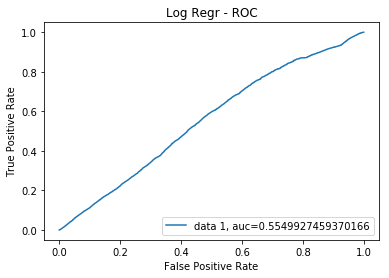

In [78]:
# Plot for No duration- Logistic Reg
y_nl_prob = loregr.predict_proba(Ftest)[:,1]
fpr, tpr, _ = roc_curve(ltest,  y_nl_prob)
auc = roc_auc_score(ltest, y_nl_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Regr - ROC')
plt.show()

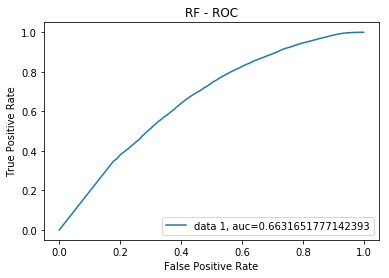

In [79]:
# Random Forest
y_nr_prob = rfc1.predict_proba(Ftest)[:, 1]
fpr_nf, tpr_nf, _ = roc_curve(ltest,  y_nr_prob)
auc = roc_auc_score(ltest, y_nr_prob)
plt.plot(fpr_nf,tpr_nf,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF - ROC')
plt.legend(loc=4)
plt.show()

In [76]:
# Confusion Matrix for Random Forest
conrandom_matrix = confusion_matrix(ltest, ypred3)  
print(conrandom_matrix)

[[  2881  15892]
 [  5188 139629]]


In [80]:
# Classification for Random Forest 
print(classification_report(ltest, ypred3))  

             precision    recall  f1-score   support

          0       0.36      0.15      0.21     18773
          1       0.90      0.96      0.93    144817

avg / total       0.84      0.87      0.85    163590



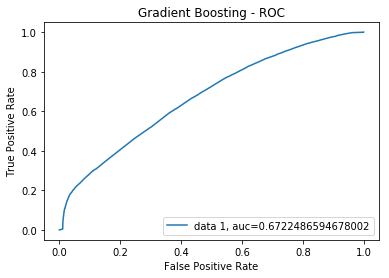

In [86]:
# Gradient Boosting- With Max Features = "sqrt”
y_ng_prob = clf1.predict_proba(Ftest)[:, 1]
fpr_ngrd, tpr_ngrd, _ = roc_curve(ltest,  y_ng_prob)
auc = roc_auc_score(ltest, y_ng_prob)
plt.plot(fpr_ngrd,tpr_ngrd,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting - ROC')
plt.legend(loc=4)
plt.show()

In [83]:
# Confusion Matrix for Gradient Boosting
congb_matrix = confusion_matrix(ltest, ypred4)  
print(congb_matrix)

[[   800  17973]
 [   434 144383]]


In [84]:
# Classification for Gradient Boosting
print(classification_report(ltest, ypred4))  

             precision    recall  f1-score   support

          0       0.65      0.04      0.08     18773
          1       0.89      1.00      0.94    144817

avg / total       0.86      0.89      0.84    163590



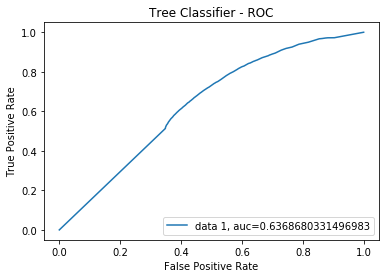

In [85]:
# Tree Classifier 
y_nt_prob = treeclass1.predict_proba(Ftest)[:,1]
fpr_nt, tpr_nt, _ = roc_curve(ltest,  y_nt_prob)
auc = roc_auc_score(ltest, y_nt_prob)
plt.plot(fpr_nt,tpr_nt,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tree Classifier - ROC')
plt.show()

For "Certified" class , precision indicates that the model 89% of the time it correctly predicted that an application will be certified. A recall of 1 for "Certified" class is good since it never says an element belongs to the opposite class whereas it actually belongs to its class.


In [87]:
# To find top contributors 
feat_names = Xtrain.columns.values

In [88]:
# Random Forest 
featr_vip = pd.Series(rfc1.feature_importances_).sort_values(ascending=False)
feat_pst = featr_vip.index.values
featr_vip.index = feat_names[feat_pst]
featr_vip

WAGE_RATE_OF_PAY_FROM                                                                0.786768
PW_WAGE_LEVEL_Level I                                                                0.021137
EMPLOYER_NAME_Other                                                                  0.014677
JOB_TITLE_PROGRAMMER ANALYST                                                         0.012451
PW_WAGE_LEVEL_Level II                                                               0.007983
EMPLOYER_NAME_HEXAWARE TECHNOLOGIES, INC.                                            0.007056
JOB_TITLE_Other                                                                      0.005470
EMPLOYER_NAME_IBM INDIA PRIVATE LIMITED                                              0.004602
WORKSITE_POSTAL_CODE_Other                                                           0.004025
JOB_TITLE_COMPUTER PROGRAMMER                                                        0.003971
PW_WAGE_LEVEL_Level III                                     

In [89]:
# Gradient 
featg_vip = pd.Series(clf1.feature_importances_).sort_values(ascending=False)
feat_p = featg_vip.index.values
featg_vip.index = feat_names[feat_p]
featg_vip

EMPLOYER_NAME_IBM INDIA PRIVATE LIMITED          2.616797e-01
WAGE_RATE_OF_PAY_FROM                            1.350621e-01
EMPLOYER_NAME_Other                              4.750153e-02
EMPLOYER_NAME_V-SOFT CONSULTING GROUP, INC       3.028639e-02
PW_WAGE_LEVEL_Level I                            2.643337e-02
PW_WAGE_LEVEL_Other                              1.926639e-02
JOB_TITLE_PROGRAMMER ANALYST                     1.873320e-02
EMPLOYER_NAME_IBM CORPORATION                    1.812144e-02
EMPLOYER_NAME_GOOGLE LLC                         1.641385e-02
JOB_TITLE_TECHNICAL LEAD                         1.488799e-02
EMPLOYER_NAME_UBER TECHNOLOGIES, INC.            1.374991e-02
EMPLOYER_NAME_APPLE INC.                         1.338448e-02
EMPLOYER_NAME_RANDSTAD TECHNOLOGIES, LLC         1.154276e-02
PW_WAGE_LEVEL_Level II                           1.100337e-02
EMPLOYER_NAME_SYNTEL INC                         1.060632e-02
WORKSITE_POSTAL_CODE_Other                       9.140523e-03
JOB_TITL

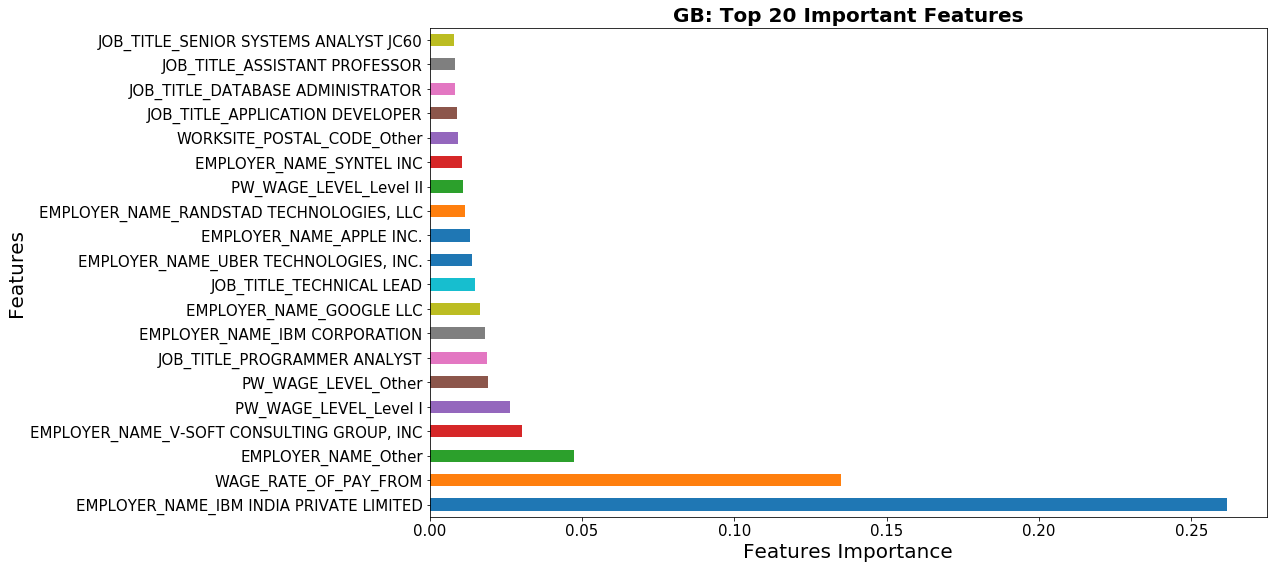

In [91]:
featg_vip.nlargest(20).plot(kind='barh', figsize=(15,9), fontsize = 15)
_= plt.xlabel('Features Importance',fontsize=20)
_= plt.ylabel('Features',fontsize=20)
_= plt.title('GB: Top 20 Important Features',fontsize=20,fontweight='bold')

### HyperParameter tuning

In [90]:
# Cross Validation Logistic Regression
from sklearn.model_selection import cross_val_score

cv_results = cross_val_score(loregr, feat_enc, label, cv=5)

print(cv_results)
print('Average Score:',np.mean(cv_results))

[0.88551496 0.88552173 0.88552173 0.88552086 0.88552086]
Average Score: 0.8855200280071335


In [91]:
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}


# Instantiate the GridSearchCV object: logreg_cv
loregr_cv = GridSearchCV(loregr, param_grid, cv=5)

# Fit it to the data. the training?
loregr_cv.fit(Xval,val_l)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(loregr_cv.best_params_)) 
print("Best score is {}".format(loregr_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 1e-05}
Best score is 0.8858207069677977


In [92]:
# Partial Dependence(python) PDP
# Hyperparameters for Random Forest 
from pprint import pprint
pprint(rfc1.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [94]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features}
pprint(random_grid)

{'max_features': ['log2', 'sqrt'],
 'n_estimators': [150, 166, 183, 200, 216, 233, 250, 266, 283, 300]}


In [95]:
# Random search of parameters, using e fold cross validation, 
rf_random = RandomizedSearchCV(rfc1, param_distributions = random_grid, n_iter = 7, cv = 3)



In [96]:
print(rf_random)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=7, n_jobs=1,
          param_distributions={'n_estimators': [150, 166, 183, 200, 216, 233, 250, 266, 283, 300], 'max_features': ['log2', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)
